# **Importing Libraries**

In [656]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

# **Importing Dataset**

In [657]:
def import_dataset(path: str, nrows: int | None = None) -> pd.DataFrame:
    chunksize = 100_000
    machine_area_df = pd.read_csv("dataset/Machine-Area.csv")
    machine_list_df = pd.read_csv("dataset/Machine-List.csv")
    area_list_df = pd.read_csv("dataset/Area-List.csv")
    machine_area_df['Last Maintenance'] = pd.to_datetime(machine_area_df['Last Maintenance'])
    machine_area_filtered_df = machine_area_df.sort_values(
        by=['ID_Area', 'ID_Mesin', 'Last Maintenance'], 
        ascending=[True, True, False]
    ).drop_duplicates(subset=['ID_Area', 'ID_Mesin'], keep='first')

    id_list = []
    chunk_list = []
    for chunk in pd.read_csv(path, chunksize=chunksize, nrows=nrows, low_memory=False):
        chunk = chunk[chunk['Machine'].isin(machine_area_df['ID_Mesin'])]
        if not chunk.empty:
            id_column = chunk.pop('ID_Transaction') if 'ID_Transaction' in chunk.columns else None
            chunk = pd.merge(chunk, area_list_df, on='ID_Area', how='left')
            chunk = pd.merge(chunk, machine_list_df, left_on='Machine', right_on='ID_Mesin', how='left')
            chunk = pd.merge(chunk, machine_area_filtered_df, left_on=['Machine', 'ID_Area'], right_on=['ID_Mesin', 'ID_Area'], how='left')
            chunk_list.append(chunk)
            if id_column is not None:
                id_list.append(id_column)
    combined_df = pd.concat(chunk_list, ignore_index=True)
    maintenance_frequency = machine_area_df.groupby('ID_Mesin').size().rename('maintenance_count')
    combined_df = pd.merge(combined_df, maintenance_frequency, left_on='Machine', right_index=True, how='left')
    id_series = pd.concat(id_list, ignore_index=True) if id_list else None
    return combined_df, id_series


In [658]:
train_df, _ = import_dataset(
    path="dataset/train.csv", 
    nrows=200_000)

In [659]:
train_df = train_df.dropna(subset=['Last Maintenance', 'Status Sparepart', 'Age'])

In [661]:
# test_df, test_id = import_dataset(
#     path="dataset/test.csv", 
#     nrows=None)

# **Data Cleaning**

## Identify Missing Data

In [662]:
missing = train_df.isnull().sum()
missing_percentage = missing / len(train_df) * 100
print(missing_percentage)

temperature_10H_max (°C)     2.833335
temperature_10H_min (°C)    18.986818
temperature-1                2.948356
temperature-2               11.421881
temperature-3                3.589663
apparent_temperature_max    21.251665
apparent_temperature_min    20.173442
ID_Area                      0.000000
Machine                      0.000000
timestamp                    0.000000
humidity                    19.398909
Voltage-L                    9.642771
Voltage-R                    6.846674
Voltage-M                    3.500294
Current-M                    1.064983
Current-R                    1.372810
Current-T                   22.749427
RPM                         11.211697
RPM-1                       13.324286
RPM-2                       18.679818
RPM-3                       18.399298
Vibration-1                  5.430007
Vibration-2                 15.119118
Power                       12.991634
Power_Backup                 3.321555
Status                       0.000000
Breakdown Ca

## Handling Missing Data

In [663]:

columns_to_impute = missing_percentage[missing_percentage < 5].index
for col in columns_to_impute:
    if train_df[col].dtype in ['float64', 'int64']:
        train_df[col] = train_df[col].fillna(train_df[col].median())

In [666]:
def drop_cols(df) :
    missing_percentage = df.isnull().sum() / len(df) * 100
    columns_to_drop = missing_percentage[missing_percentage > 5].index
    df = df.drop(columns=columns_to_drop)
    return df, columns_to_drop
    

## Dealing with Outliers

## Remove Duplicates

## Feature Engineering

# **Data Preprocessing**

## Feature Scaling

In [669]:
def scaler(df):
    numerical_cols = [col for col in df.columns if df[col].dtype in ['float64', 'int64']]
    scaler = StandardScaler()
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
    return df


## Dimensionality Reduction

### bisa pake feature hasher buat categorical

In [670]:
def reduce_dim(df, dim):
    cols_to_reduce = ['temperature_10H_max (°C)',
                      'temperature-1', 'temperature-3',
                      'Voltage-M', 'Current-M', 'Current-R']
    X = df[cols_to_reduce]
    input_dim = X.shape[1]

    input_layer = Input(shape=(input_dim,))
    encoder = Dense(dim, activation='relu')(input_layer)
    encoder = BatchNormalization()(encoder)
    decoder = Dense(input_dim, activation='sigmoid')(encoder)
    autoencoder = Model(inputs=input_layer, outputs=decoder)

    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.fit(X, X, epochs=22, batch_size=32, shuffle=True, validation_split=0.2)

    encoder_model = Model(inputs=input_layer, outputs=encoder)
    X_reduced = encoder_model.predict(X)
    X_reduced = pd.DataFrame(X_reduced, columns=[f'feature_{i}' for i in range(dim)], index=X.index)
    df.drop(cols_to_reduce, axis=1, inplace=True)
    df = pd.concat([df, X_reduced], axis=1)
    return df, encoder_model, cols_to_reduce

In [671]:
def predict_reduce_dim(df, encoder_model, cols_to_reduce) :
    X = df[cols_to_reduce].copy()
    for col in X.columns:
        X[col] = pd.to_numeric(X[col], errors='coerce')
    X_reduced = encoder_model.predict(X)
    dim = X_reduced.shape[1]
    X_reduced = pd.DataFrame(X_reduced, columns=[f'feature_{i}' for i in range(dim)], index=df.index)

    df.drop(cols_to_reduce, axis=1, inplace=True)
    df = pd.concat([df, X_reduced], axis=1)
    return df

## Feature Encoding

In [672]:
def one_hot_encode(df, cols):
    if df[cols].isnull().any():
        df[cols] = df[cols].fillna("Missing")
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    onehot_encoded = encoder.fit_transform(df[[cols]])
    encoded_df = pd.DataFrame(onehot_encoded, columns=encoder.get_feature_names_out([cols]), index = df.index)
    for column in encoded_df.columns:
        encoded_df[column] = pd.Categorical(encoded_df[column])
    df_encoded = pd.concat([df.drop(columns=cols), encoded_df], axis=1)
    return df_encoded

In [673]:
def time_encoding(df):
    df['Last Maintenance'] = pd.to_datetime(df['Last Maintenance'])
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['days_since_last_maintenance'] = (df['timestamp'] - df['Last Maintenance']).dt.days
    df.drop(['Last Maintenance', 'timestamp'], axis=1, inplace=True)
    return df

## Handling Imbalanced Dataset

In [674]:
def smote_transform(df):
    target = df['Status'].map({'Normal': 0, 'Warning': 1, 'Breakdown': 2})
    df = df.drop('Status', axis=1)
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(df, target)
    X_resampled = pd.DataFrame(X_resampled, columns=df.columns)
    X_resampled['Status'] = y_resampled
    return X_resampled

# Pipeline

In [675]:
def pipeline(df, is_train=False, encoder_model=None, cols_to_reduce=None):
    cols_to_reduce=[]
    df = scaler(df)
    if is_train:
        df, columns_to_drop = drop_cols(df)
        df, encoder_model, cols_to_reduce = reduce_dim(df, 3)
    else:
        df = df.drop(columns_to_drop, axis=1)
        if encoder_model is None or cols_to_reduce is None:
            raise ValueError("For non-training data, 'encoder_model' and 'cols_to_reduce' must be provided.")
        df = predict_reduce_dim(df, encoder_model, cols_to_reduce)   
    df = time_encoding(df)
    df['Priority'] = df['Priority'].map({'Low': 0, 'Medium': 1, 'High': 2})
    df = one_hot_encode(df, 'Status Sparepart')
    df = one_hot_encode(df, 'Power_Backup')
    for col in df.select_dtypes(include=['category']).columns:
        df[col] = df[col].cat.add_categories([-1])
        df[col] = df[col].fillna(-1)
    df['maintenance_count'] = df['maintenance_count'].fillna(0, inplace=True)
    if is_train:
        df = smote_transform(df)
    return df, encoder_model, cols_to_reduce

# **Modelling & Validation**

In [676]:
train_df, encoder_model, cols_to_reduce = pipeline(train_df, is_train=True)

Epoch 1/22
3022/3022 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.9969 - val_loss: 0.7787
Epoch 2/22
3022/3022 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.7620 - val_loss: 0.7717
Epoch 3/22
3022/3022 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.7738 - val_loss: 0.7701
Epoch 4/22
3022/3022 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.7740 - val_loss: 0.7692
Epoch 5/22
3022/3022 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.7684 - val_loss: 0.7687
Epoch 6/22
3022/3022 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.7736 - val_loss: 0.7684
Epoch 7/22
3022/3022 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.7655 - val_loss: 0.7682
Epoch 8/22
3022/3022 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.7890 - val_loss: 0.7680
Epoch 9/22
3022/3022 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.7934 - val_loss: 0.7677
Epoch 10/22
3022/3022 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.7626 - val_loss: 0.7615
Epoch 11/22
3022/3022 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 0.7604 - val_loss: 0.7607
Epoch 12/22
3022/3022 ━━━━━━

ValueError: could not convert string to float: 'ID12'

In [ ]:
train_df.isnull().sum()

ID_Area              32938
Machine              32938
timestamp            32938
Power_Backup         36952
Status               32938
Area                 32938
Priority             32938
ID_Mesin_x           32938
Mesin_x              32938
Country Machine_x    32938
ID_Mesin_y           32938
Mesin_y              32938
Country Machine_y    32938
Last Maintenance     32938
Status Sparepart     32938
Age                  32938
maintenance_count    32938
feature_0            32938
feature_1            32938
feature_2            32938
dtype: int64

In [329]:
# num_chunks = len(test_df) // 100000 + (len(test_df) % 100000 > 0)
# chunks = np.array_split(test_df, num_chunks)
# processed_chunks = []

# for chunk in chunks:
#     processed_chunk, _, a = pipeline(chunk, is_train=False, encoder_model=encoder_model, cols_to_reduce=cols_to_reduce)
#     processed_chunks.append(processed_chunk)

# testing = pd.concat(processed_chunks, ignore_index=True)

In [330]:
# test_df.to_csv("test_processed.csv", index=False)

In [331]:
# chunk_size = 100_000
# chunk_list = []
# for chunk in pd.read_csv("test_processed.csv", chunksize=chunk_size, low_memory=False):
#     chunk_list.append(chunk)

# test_df = pd.concat(chunk_list, ignore_index=True)

In [332]:
X = train_df.drop(columns='Status')
y = train_df['Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [333]:
y.value_counts()

Status
1    123236
0    123236
2    123236
Name: count, dtype: int64

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.86      0.72     24576
           1       0.71      0.57      0.64     24675
           2       0.72      0.58      0.64     24691

    accuracy                           0.67     73942
   macro avg       0.68      0.67      0.67     73942
weighted avg       0.68      0.67      0.67     73942



In [ ]:
#print f1
from sklearn.metrics import f1_score

f1_score(y_test, y_pred, average='macro')

0.6657907929419715

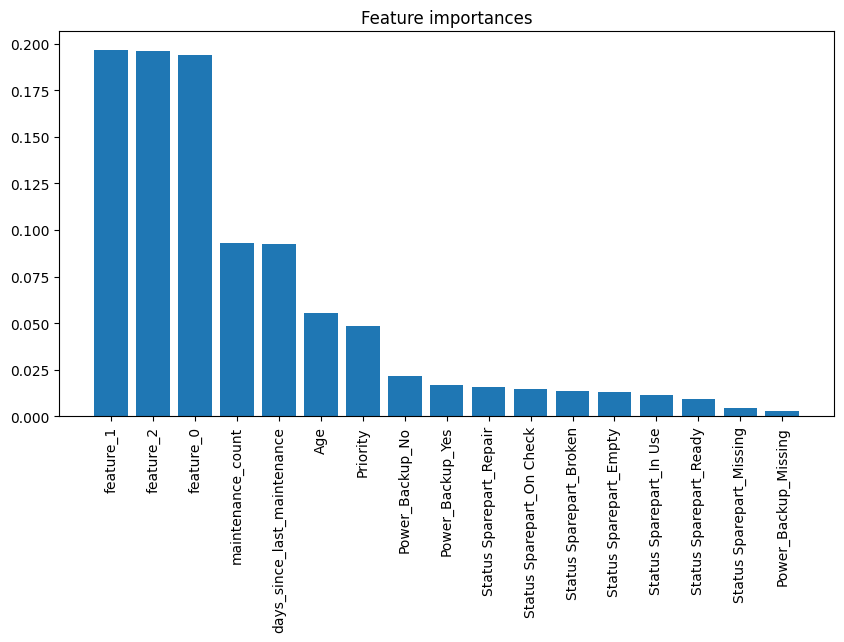

In [336]:
#feateure importance
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X_train.columns

plt.figure(figsize=(10, 5))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), [features[i] for i in indices], rotation=90)
plt.show()

In [337]:
def predict_in_chunks(test_df, model, batch_size=1000, preprocess_fn=None):
    chunks = np.array_split(test_df, len(test_df) // batch_size + 1)
    predictions = []
    
    for i, chunk in enumerate(chunks):
        print(f"Processing chunk {i + 1}/{len(chunks)}...")
        preds = model.predict(chunk)
        predictions.append(preds)
    all_predictions = np.concatenate(predictions, axis=0)
    
    return all_predictions


In [ ]:
#rename col
testing.rename(columns={'Power_Backup_ ': 'Power_Backup_Missing'}, inplace=True)

NameError: name 'testing' is not defined

In [73]:
predictions = predict_in_chunks(testing, xgb_model, batch_size=100000)

c:\Users\farel\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Processing chunk 1/71...
Processing chunk 2/71...
Processing chunk 3/71...
Processing chunk 4/71...
Processing chunk 5/71...
Processing chunk 6/71...
Processing chunk 7/71...
Processing chunk 8/71...
Processing chunk 9/71...
Processing chunk 10/71...
Processing chunk 11/71...
Processing chunk 12/71...
Processing chunk 13/71...
Processing chunk 14/71...
Processing chunk 15/71...
Processing chunk 16/71...
Processing chunk 17/71...
Processing chunk 18/71...
Processing chunk 19/71...
Processing chunk 20/71...
Processing chunk 21/71...
Processing chunk 22/71...
Processing chunk 23/71...
Processing chunk 24/71...
Processing chunk 25/71...
Processing chunk 26/71...
Processing chunk 27/71...
Processing chunk 28/71...
Processing chunk 29/71...
Processing chunk 30/71...
Processing chunk 31/71...
Processing chunk 32/71...
Processing chunk 33/71...
Processing chunk 34/71...
Processing chunk 35/71...
Processing chunk 36/71...
Processing chunk 37/71...
Processing chunk 38/71...
Processing chunk 39/7

In [74]:
submission = pd.read_csv("dataset/submission.csv")

In [75]:
test_predictions = pd.DataFrame({
    'ID_Transaction': test_id,
    'Status': predictions})

test_predictions['Status'] = test_predictions['Status'].map({0: 'Normal', 1: 'Warning', 2: 'Breakdown'})

In [76]:
test_predictions['Status'].value_counts()

Status
Normal       4431862
Breakdown    1676108
Warning       892030
Name: count, dtype: int64

In [77]:
test_predictions.to_csv("submission4.csv", index=False)

In [57]:
submission = pd.merge(submission, test_predictions, on='ID_Transaction', how='left')

In [59]:
submission = submission.drop(columns='Status_x')

In [61]:
submission.fillna('Normal', inplace=True)

In [62]:
submission.to_csv("submission1.csv", index=False)

In [47]:
# Keep only the column from the predictions DataFrame
submission = submission.drop(columns=['Status_x'])  # Adjust the column name as needed

# Optionally rename 'Status_y' to 'Target' (or your desired name)
submission.rename(columns={'Status_y': 'Status'}, inplace=True)


In [48]:
submission.to_csv("submission1.csv", index=False)

# **Result & Analysis**